# Código independiente de la técnica utilizada

In [ ]:
#Instalaciones
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
#Librerías
import os
import numpy as np
import pandas as pd
import glob
import shutil
import torch
import torch.nn.functional as F
from torch import nn
from google.colab import drive
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, f1_score
from torch.optim import Adam
from sklearn.model_selection import ParameterGrid
from datasets import concatenate_datasets

In [ ]:
#Carga del dataset de España
dataset_es = load_dataset("alttal/SA_opiniones_indumentaria_ES_Espanya_splits")

In [ ]:
#Se eliminan columnas innecesarias
dataset_es = dataset_es.remove_columns(["id","__index_level_0__"])
dataset_es

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2187
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

In [ ]:
#Las etiquetas de los datasets son strings. Se las cambia a valores numéricos
def label_to_int(label):
    if label == "POS":
        return 2
    elif label == "NEG":
        return 0
    else:
        return 1

dataset_es_1 = dataset_es.map(lambda x: {"label": label_to_int(x["label"])})

In [ ]:
dataset_es_1

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2187
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

In [ ]:
from collections import Counter

#Actual distribución de clases en el split de entrenamiento
label_counts = Counter(dataset_es_1['train']['label'])
max_class_count = max(label_counts.values())

print("Distribución de clases en el split de entrenamiento:")
for label, count in label_counts.items():
    print(f"Clase {label}: {count} instancias")

#Calcular cuántos ejemplos adicionales se necesitan para balancear las clases tomando como referencia la clase mayoritaria
needed_neutral_examples = max_class_count - label_counts[1]
print(f"\nSe necesitan {needed_neutral_examples} ejemplos adicionales para la clase neutral.")
needed_negative_examples = max_class_count - label_counts[0]
print(f"\nSe necesitan {needed_negative_examples} ejemplos adicionales para la clase negativa.")

Distribución de clases en el split de entrenamiento:
Clase 0: 869 instancias
Clase 2: 1002 instancias
Clase 1: 316 instancias

Se necesitan 686 ejemplos adicionales para la clase neutral.

Se necesitan 133 ejemplos adicionales para la clase negativa.


# Técnica utilizando nlpaug

In [ ]:
!pip install nlpaug

In [ ]:
import nlpaug.augmenter.word as naw
from datasets import Dataset, DatasetDict, concatenate_datasets

#Filtrar instancias de las clases negativa (0) y neutral (1) en el split de entrenamiento
train_class_0 = dataset_es_1['train'].filter(lambda example: example['label'] == 0)
train_class_1 = dataset_es_1['train'].filter(lambda example: example['label'] == 1)

#Configurar el objeto augmenter (aumentador)
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

#Generar instancias adicionales para la clase negativa (0)
needed_neutral_examples = max_class_count - label_counts[0]
augmented_texts_0 = []
for text in train_class_0['text']:
    n_aug = needed_neutral_examples // len(train_class_0) + 1
    augmented_texts_0.extend(aug.augment(text, n=n_aug))
augmented_texts_0 = augmented_texts_0[:needed_neutral_examples]

#Generar instancias adicionales para la clase neutral (1)
needed_negative_examples = max_class_count - label_counts[1]
augmented_texts_1 = []
for text in train_class_1['text']:
    n_aug = needed_negative_examples // len(train_class_1) + 1
    augmented_texts_1.extend(aug.augment(text, n=n_aug))
augmented_texts_1 = augmented_texts_1[:needed_negative_examples]

#Creación de un nuevo dataset con las instancias adicionales negativas
augmented_dataset_0 = Dataset.from_dict({
    'text': augmented_texts_0,
    'label': [0] * len(augmented_texts_0)
})

#Creación de un nuevo dataset con las instancias adicionales neutrales
augmented_dataset_1 = Dataset.from_dict({
    'text': augmented_texts_1,
    'label': [1] * len(augmented_texts_1)
})

#Combinar las instancias originales con las instancias adicionales en un único dataset (split de entrenamiento)
combined_train_dataset = concatenate_datasets([dataset_es_1['train'], augmented_dataset_0, augmented_dataset_1])

#Concatenar este nuevo split de entrenamiento con los otros splits para crear el DatasetDict final
combined_dataset = DatasetDict({
    'train': combined_train_dataset,
    'test': dataset_es_1['test'],
    'validation': dataset_es_1['validation']
})
dataset_es_1

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2187
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

In [ ]:
combined_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3006
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

In [ ]:
##Distribución de clases en el split de entrenamiento tras la técnica de data augmentation
label_counts = Counter(combined_dataset['train']['label'])
max_class_count = max(label_counts.values())

print("Distribución de clases en el entrenamiento:")
for label, count in label_counts.items():
    print(f"Clase {label}: {count} ejemplos")

Distribución de clases en el entrenamiento:
Clase 0: 1002 ejemplos
Clase 2: 1002 ejemplos
Clase 1: 1002 ejemplos


In [ ]:
#Algunos ejemplos de las instancias creadas para la clase negativa
augmented_dataset_0[0:15]

{'text': ['yo me de una luna que tan tu talla la quedan e no quedan ajustados da gran sensacion de cuando te estan estirajeados no los o que',
  'dan... don',
  'tiene un corte raro como se me va y te estrechos si espalda hombros una sol no de te suave',
  'lo era calidad es muy me al era ya los de que tirar es contra la',
  'relacion calidad para muy mis o que era no es',
  'la se corresponde las talla son no me',
  'fabricacion con el la ley de la manga con la hombrera como es correcta tiene excesivo sobrante es uno mas grande que el de su sol y me se ahora sin 5799€ por ti mismo color en otros colores 78€ si del precio dependiese la calidad decir de abriga',
  'estas bragas tienen buen material son de algodon elastico el problema mas que no son ni de lejos como en la foto en la foto llegan hasta el ombligo no es asi suben mucho mas arriba del mundo y mitad del estomago no es porque yo este esmirriada ni porque sera en una talla demasiado grande simplemente estan mal hechas se les ha

Probando la API del modelo finiteautomata/beto-sentiment-analysis, estos son los resultados para los ejemplos adicionales la clase negativa.

Link: https://huggingface.co/finiteautomata/beto-sentiment-analysis


*   yo me de una luna que tan tu talla la quedan e no quedan ajustados da gran sensacion de cuando te estan estirajeados no los o que = NEG
*   dan... don = NEU
*   tiene un corte raro como se me va y te estrechos si espalda hombros una sol no de te suave = NEG
*   lo era calidad es muy me al era ya los de que tirar es contra la = NEG
*   relacion calidad para muy mis o que era no es = NEG
*   la se corresponde las talla son no me = NEU
*   fabricacion con el la ley de la manga con la hombrera como es correcta tiene excesivo sobrante es uno mas grande que el de su sol y me se ahora sin 5799€ por ti mismo color en otros colores 78€ si del precio dependiese la calidad decir de abriga = NEU
*   estas bragas tienen buen material son de algodon elastico el problema mas que no son ni de lejos como en la foto en la foto llegan hasta el ombligo no es asi suben mucho mas arriba del mundo y mitad del estomago no es porque yo este esmirriada ni porque sera en una talla demasiado grande simplemente estan mal hechas se les ha puesto el anadido sobre la cintura una franja que es demasiado ancha es una sensacion de agobio tal el llevarlas que resultan incomodas por otra parte se dificulta mucho mi manejo al ir al servicio se ven por fuera del diablo no resumen a un engorro de bragas si lo llego saber no las compro = NEG
*   al colorado que es muy fiable es el pequeno a si que po = NEU
*   llevo anos usando esta marca de sujetadores ya me ha decepcionado las gomas se lo solo en el ahora parece si se el es la = NEG
*   2 anos que compro esta marca esta ultima vez se han descosido le por hay otro lado en menos que seis meses tengo el sur producto con antiguedad de mas de 3 anos o estan en mi mejor u ck ha bajado ma calidad hasta lo punto de ser muy malos = NEG
*   el son no es la que le al la opinion los detalles tenian que una en rojo para se ox = NEU
*   empezare con la amor para ir y del grano lo lave antes de utilizarlo como hago a con la ropa las toallas tras la primera ducha so no seque con el me di cuenta de que me habia dejado pelusillas por todo el cuerpo asi que lo he metido de nuevo en la lavadora ver si paran de salir por otro lado si mirais las fotos es se se aprecian marcas naranjas en algunas zonas el color popular esperaba mas azulado como la foto en realidad es gris = NEU
*   muy le comodo pero al mi lavadora ya tiene le paso de bolas en te foto es la tiene cremallera en mil reyes de las chaqueta no tiene = POS
*   estoy decepccionada con el sur ya para uno es importante las medidas reales cosa es en este caso no hera la calidad como normativa debe llevarla en la etiqueta en el que pone que cosa que tambien considero importante pues en el tres mas que es de algodo = NEG

**Resultados**: El modelo identifica 8/15 (53%) de las instancias adicionales como negativas. No quiere decir que el modelo funcione mal ni bien. Si se observan las instancias adicionales creadas, no son estrictamente negativas. Un anotador podría también etiquetarlas como de otra clase. Esto es sólo una demostración de que la creación de instancias adicionales no es una garantía de mejores resultados.


In [ ]:
#Algunos ejemplos de las instancias creadas para la clase neutral
augmented_dataset_1[0:15]

{'text': ['no esta lo que como me queda muy holgado en que con del estrecho en se tanto de que devolver',
  'no es mal que mi me queda muy que em tu zonas como estrecho que lo tanto para fra ॥',
  'no esta mal con tu mas no muy no por los zonas me estrecho en lo tanto y voy devolver',
  'y el poco fin de talla',
  'a a poco en de talla',
  'es un o es de mas',
  '¡ y la que este le corto de jesus ॥ ॥',
  'se tu era pero este un de mas mangas algo que',
  'siempre uso en ser so es pueblo a mangas en era',
  'lo solo pero se mucho calor de incomodar se que lo',
  'a tu pero dan solo para llegan de se con calurosos',
  'a comodas pero la a calor llegan solo te como se',
  'no te mal pero dos modelos mas son que ya mejor hay favor mas de barrio que ।',
  've esta mal que tiene modelos mas la que fe de que mas mas el mal de compre',
  'kevin esta era pero las modelos y se que quedan los en al para el azul que compre'],
 'label': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Probando la API del modelo finiteautomata/beto-sentiment-analysis, estos son los resultados para los ejemplos adicionales la clase neutral.

Link: https://huggingface.co/finiteautomata/beto-sentiment-analysis


*   no esta lo que como me queda muy holgado en que con del estrecho en se tanto de que devolver = NEG
*   no es mal que mi me queda muy que em tu zonas como estrecho que lo tanto para fra ॥ = POS
*   no esta mal con tu mas no muy no por los zonas me estrecho en lo tanto y voy devolver = POS
*   y el poco fin de talla = NEG
*   a a poco en de talla = NEU
*   es un o es de mas = NEU
*   ¡ y la que este le corto de jesus ॥ ॥ = NEG
*   se tu era pero este un de mas mangas algo que = NEU
*   siempre uso en ser so es pueblo a mangas en era = NEU
*   lo solo pero se mucho calor de incomodar se que lo = NEG
*   a tu pero dan solo para llegan de se con calurosos = NEG
*   a comodas pero la a calor llegan solo te como se = NEU
*   no te mal pero dos modelos mas son que ya mejor hay favor mas de barrio que । = POS
*   ve esta mal que tiene modelos mas la que fe de que mas mas el mal de compre = NEG
*   kevin esta era pero las modelos y se que quedan los en al para el azul que compre = NEU

**Resultados**: El modelo identifica 6/15 (40%) de las instancias adicionales como neutras. No quiere decir que el modelo funcione mal ni bien. Si se observan las instancias adicionales creadas, no son estrictamente neutrales. Un anotador podría también etiquetarlas como de otra clase. Esto es sólo una demostración de que la creación de instancias adicionales no es una garantía de mejores resultados.

# Técnica backtranslation

In [ ]:
!pip install transformers datasets

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset, DatasetDict, concatenate_datasets
from collections import Counter

#Cargar los modelos y tokenizadores para la primera traducción (ES -> EN)
model_es_en = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-es-en')
tokenizer_es_en = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-es-en')

#Cargar los modelos y tokenizadores para la segunda traducción (EN -> ES)
model_en_es = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-es')
tokenizer_en_es = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-es')

#Función para traducir de ES a EN y de vuelta al ES
def back_translate(text):
    # Traducción de español a inglés
    translated = model_es_en.generate(**tokenizer_es_en(text, return_tensors="pt", padding=True))
    english_text = tokenizer_es_en.batch_decode(translated, skip_special_tokens=True)

    # Traducción de inglés a español
    retranslated = model_en_es.generate(**tokenizer_en_es(english_text, return_tensors="pt", padding=True))
    back_translated_text = tokenizer_en_es.batch_decode(retranslated, skip_special_tokens=True)

    return back_translated_text[0]

#Actual distribución de clases en el split de entrenamiento
label_counts = Counter(dataset_es_1['train']['label'])
max_class_count = max(label_counts.values())

#Calcular cuántos ejemplos adicionales se necesitan para balancear las clases tomando como referencia la clase mayoritaria
needed_neutral_examples = max_class_count - label_counts[1]
print(f"\nSe necesitan {needed_neutral_examples} ejemplos adicionales para la clase neutral.")
needed_negative_examples = max_class_count - label_counts[0]
print(f"\nSe necesitan {needed_negative_examples} ejemplos adicionales para la clase negativa.")

#Filtrar instancias de las clases negativa (0) y neutral (1) en el split de entrenamiento
train_class_0 = dataset_es_1['train'].filter(lambda example: example['label'] == 0)
train_class_1 = dataset_es_1['train'].filter(lambda example: example['label'] == 1)

#Lista para ir agregando las instancias adicionales de la clase neutral
augmented_texts_1 = []
texts_to_augment = train_class_1['text']
#Generar instancias necesarias
while len(augmented_texts_1) < needed_neutral_examples:
    for text in texts_to_augment:
        if len(augmented_texts_1) < needed_neutral_examples:
            augmented_texts_1.append(back_translate(text))
        else:
            break

#Lista para ir agregando las instancias adicionales de la clase negativa
augmented_texts_0 = []
texts_to_augment = train_class_0['text']
#Generar instancias necesarias
while len(augmented_texts_0) < needed_negative_examples:
    for text in texts_to_augment:
        if len(augmented_texts_0) < needed_negative_examples:
            augmented_texts_0.append(back_translate(text))
        else:
            break

#Creación de un nuevo dataset con las instancias adicionales negativas
augmented_dataset_0 = Dataset.from_dict({
    'text': augmented_texts_0,
    'label': [0] * len(augmented_texts_0)
})

#Creación de un nuevo dataset con las instancias adicionales neutrales
augmented_dataset_1 = Dataset.from_dict({
    'text': augmented_texts_1,
    'label': [1] * len(augmented_texts_1)
})

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")



Se necesitan 686 ejemplos adicionales para la clase neutral.

Se necesitan 133 ejemplos adicionales para la clase negativa.


In [ ]:
##Distribución de clases en el split de entrenamiento tras la técnica de data augmentation
label_counts = Counter(combined_dataset['train']['label'])
max_class_count = max(label_counts.values())

print("Distribución de clases en el entrenamiento:")
for label, count in label_counts.items():
    print(f"Clase {label}: {count} ejemplos")

Distribución de clases en el entrenamiento:
Clase 0: 1002 ejemplos
Clase 2: 1002 ejemplos
Clase 1: 1002 ejemplos


In [ ]:
#Algunos ejemplos de las instancias creadas para la clase negativa
augmented_dataset_0[0:15]

{'text': ['Pedí un 40, que es de mi tamaño, me quedo corto, no se ponen apretados.',
  'Hacen un montón de tamaño.',
  'tiene un corte raro que no me cómodo hombros traseros muy estrechos el material es agradable suave luz',
  'Pero la calidad es muy mala en el momento ya tienes que tirarlos son muy caros',
  'Relación calidad precio muy caro Espero que me dure el tiempo suficiente',
  'el tamaño no coincide son muy grandes',
  'fabricación con fallo la conexión de la manga con la correa del hombro no es correcto tiene exceso es uno más grande que el de su otro lado me cuesta ahora 5799€ en el mismo color en otros colores 78€ si el precio depende de la calidad para decir que alberga',
  'Estas bragas tienen buen material son algodón elástico el problema es que ni siquiera están lejos ya que en la foto llegan al ombligo no es mucho más alto hasta el ombligo hasta el centro del estómago no es porque yo esta esmirriada ni porque ha tomado una talla demasiado grande simplemente están mal h

Probando la API del modelo finiteautomata/beto-sentiment-analysis, estos son los resultados para los ejemplos adicionales la clase negativa.

Link: https://huggingface.co/finiteautomata/beto-sentiment-analysis



*   Pedí un 40, que es de mi tamaño, me quedo corto, no se ponen apretados. = NEU
*   Hacen un montón de tamaño. = NEU
*   tiene un corte raro que no me cómodo hombros traseros muy estrechos el material es agradable suave luz = NEU
*   Pero la calidad es muy mala en el momento ya tienes que tirarlos son muy caros = NEG
*   Relación calidad precio muy caro Espero que me dure el tiempo suficiente = NEU
*   el tamaño no coincide son muy grandes = NEU
*   fabricación con fallo la conexión de la manga con la correa del hombro no es correcto tiene exceso es uno más grande que el de su otro lado me cuesta ahora 5799€ en el mismo color en otros colores 78€ si el precio depende de la calidad para decir que alberga = NEG
*   Estas bragas tienen buen material son algodón elástico el problema es que ni siquiera están lejos ya que en la foto llegan al ombligo no es mucho más alto hasta el ombligo hasta el centro del estómago no es porque yo esta esmirriada ni porque ha tomado una talla demasiado grande simplemente están mal hechas se ha puesto un añadido en la cintura una tira que es demasiado ancha es una sensación de desbordamiento tal que son incómodos por otro lado es muy difícil de manejar cuando van al servicio que se ven fuera del pantalón en resumen son un engorro de bragas si sé que no las compra = NEG
*   la talla no es muy confiable es más pequeña que la que esperaba = NEG
*   He estado usando esta marca de sujetadores durante años, este me ha decepcionado, los condones han venido de si ahora parece que está atado con cuerdas. = NEG
*   hace años compré esta marca esta última vez que todos han caído por un lado en menos de seis meses tengo el mismo producto con antigüedad de más de tres años que están en mejores condiciones ck ha ido hasta el punto de ser muy malo = NEG
*   los pantalones no son los que ponen en la foto los detalles tenían que estar en rojo no en blanco = NEU
*   Empezaré con los peros para llegar directamente al punto en el que lo lavo antes de siempre usarlo con la ropa las toallas después de la primera ducha mientras me seco con ella me di cuenta de que había dejado pelos por todo mi cuerpo así que lo puse de nuevo en la lavadora ver si dejan de salir de la otra manera si miras las imágenes adjuntas marcas naranjas se aprecian en algunas áreas el color esperado más azulado como la foto es realmente gris = NEU
*   muy agradable cómodo pero la segunda lavadora ya tiene un montón de bolas en la foto sale que tiene cremallera en los bolsillos de la chaqueta no tiene = NEU
*   Soy engañoso con el producto porque para mí es importante las medidas reales que en este caso no dañan la calidad como estándar debe ser llevado en la etiqueta en esto no pone nada que también considero importante porque en el catálogo dice que es 95 algodón = NEU

**Resultados**: El modelo identifica 5/15 (33%) de las instancias adicionales como negativas. No quiere decir que el modelo funcione mal ni bien. Si se observan las instancias adicionales creadas, no son estrictamente negativas. Un anotador podría también etiquetarlas como de otra clase. Esto es sólo una demostración de que la creación de instancias adicionales no es una garantía de mejores resultados.

In [ ]:
#Algunos ejemplos de las instancias creadas para la clase neutral
augmented_dataset_1[0:15]

{'text': ['No está mal, pero estoy muy relajado en algunas áreas muy estrechas, así que voy a devolverlo.',
  'Es sólo un poco de un tamaño.',
  'Siempre uso el pero éste es mangas cortas algo estrechas',
  'Están cómodos, pero están muy calientes, se sienten incómodos en los días calurosos.',
  'No está mal, pero tiene modelos más cómodos que se ven mejor me gusta el azul que compro',
  'la chaqueta muy bien, pero el tamaño es pequeño!',
  'este producto se ha confundido los otros cinco muy bien',
  'el producto entrega estrellas pero que el producto viene en una bolsa transparente no me parece bueno lo que compro tiene que ser genoose otras personas',
  'el modelo el tamaño es el correcto pero le falta un poco en el área de la sisa sin embargo un tamaño más grande del pecho falta un poco para adaptarse al cuerpo',
  'Para las niñas menores de 40 años va a ir bien',
  'el tamaño del producto más grande de lo habitual tiene una calidad básica',
  'Me gustó muy cálido no pesado fácil de

Probando la API del modelo finiteautomata/beto-sentiment-analysis, estos son los resultados para los ejemplos adicionales la clase neutral.

Link: https://huggingface.co/finiteautomata/beto-sentiment-analysis



*   No está mal, pero estoy muy relajado en algunas áreas muy estrechas, así que voy a devolverlo. = POS
*   Es sólo un poco de un tamaño. = NEU
*   Siempre uso el pero éste es mangas cortas algo estrechas = NEU
*   Están cómodos, pero están muy calientes, se sienten incómodos en los días calurosos. = NEU
*   No está mal, pero tiene modelos más cómodos que se ven mejor me gusta el azul que compro = POS
*   la chaqueta muy bien, pero el tamaño es pequeño! = NEU
*   este producto se ha confundido los otros cinco muy bien = NEG
*   el producto entrega estrellas pero que el producto viene en una bolsa transparente no me parece bueno lo que compro tiene que ser genoose otras personas = NEG
*   el modelo el tamaño es el correcto pero le falta un poco en el área de la sisa sin embargo un tamaño más grande del pecho falta un poco para adaptarse al cuerpo = NEU
*   Para las niñas menores de 40 años va a ir bien = POS
*   el tamaño del producto más grande de lo habitual tiene una calidad básica = POS
*   Me gustó muy cálido no pesado fácil de llevar primero compré el verde entonces he repetido con el rojo si he notado el género diferente de un color otro que las mangas del rojo son más estrechas una película más corta siendo el mismo tamaño pero todavía lo recomiendo he decidido en un tercio en negro me han traído una camisa triste que para nada se ve muy mal para Amazon cometer fallos de esta magnitud para proceder a volver tengo que perder mucho tiempo de los cuales no tengo disponible ninguna manera de contacto con el vendedor para hacer el cambio patético!!!!!!!!!!!!!!! = NEG
*   un poco pequeño para el resto es lo que se espera = NEU
*   El precio de calidad diría que está bien pero el material es bajo parece que se romperá en cualquier momento ya he sido enganchado un par de veces porque es demasiado delgado lo bueno es que se pliega es súper compacto = POS
*   Lo compré por la forma en que el color que se ve muy bien es suave por dentro, sin embargo, no ser conocido marca es caro = NEU

**Resultados**: El modelo identifica 7/15 (47%) de las instancias adicionales como neutras. No quiere decir que el modelo funcione mal ni bien. Si se observan las instancias adicionales creadas, no son estrictamente neutrales. Un anotador podría también etiquetarlas como de otra clase. Esto es sólo una demostración de que la creación de instancias adicionales no es una garantía de mejores resultados.

**Elección de la técnica**:

La pregunta es: ¿etiquetaría un anotador las instancias adicionales para la clase neutral como neutrales y las instancias adicionales creadas para la clase negativa como negativa? Después de todo, debe existir una coherencia entre el etiquetado original y el etiquetado realizado a través de las técnicas de data augmentation.

Las instancias creadas con la librería nlpaug.augmenter.word no son muy comprensibles y por ende, difíciles de etiquetar. Por este motivo, se intentará etiquetar manualmente las instancias creadas a través de **backtranslation**, que contienen textos claros y comprensibles.

**Etiquetado manual de las clases supuestamente negativas:**

*   Pedí un 40, que es de mi tamaño, me quedo corto, no se ponen apretados. = NEG
*   Hacen un montón de tamaño. = NEG
*   tiene un corte raro que no me cómodo hombros traseros muy estrechos el material es agradable suave luz = NEU
*   Pero la calidad es muy mala en el momento ya tienes que tirarlos son muy caros = NEG
*   Relación calidad precio muy caro Espero que me dure el tiempo suficiente = NEG
*   el tamaño no coincide son muy grandes =  NEG
*   fabricación con fallo la conexión de la manga con la correa del hombro no es correcto tiene exceso es uno más grande que el de su otro lado me cuesta ahora 5799€ en el mismo color en otros colores 78€ si el precio depende de la calidad para decir que alberga = NEG
*   Estas bragas tienen buen material son algodón elástico el problema es que ni siquiera están lejos ya que en la foto llegan al ombligo no es mucho más alto hasta el ombligo hasta el centro del estómago no es porque yo esta esmirriada ni porque ha tomado una talla demasiado grande simplemente están mal hechas se ha puesto un añadido en la cintura una tira que es demasiado ancha es una sensación de desbordamiento tal que son incómodos por otro lado es muy difícil de manejar cuando van al servicio que se ven fuera del pantalón en resumen son un engorro de bragas si sé que no las compra = NEG
*   la talla no es muy confiable es más pequeña que la que esperaba = NEG
*   He estado usando esta marca de sujetadores durante años, este me ha decepcionado, los condones han venido de si ahora parece que está atado con cuerdas. = NEG
*   hace años compré esta marca esta última vez que todos han caído por un lado en menos de seis meses tengo el mismo producto con antigüedad de más de tres años que están en mejores condiciones ck ha ido hasta el punto de ser muy malo = NEG
*   los pantalones no son los que ponen en la foto los detalles tenían que estar en rojo no en blanco = NEG
*   Empezaré con los peros para llegar directamente al punto en el que lo lavo antes de siempre usarlo con la ropa las toallas después de la primera ducha mientras me seco con ella me di cuenta de que había dejado pelos por todo mi cuerpo así que lo puse de nuevo en la lavadora ver si dejan de salir de la otra manera si miras las imágenes adjuntas marcas naranjas se aprecian en algunas áreas el color esperado más azulado como la foto es realmente gris = NEG
*   muy agradable cómodo pero la segunda lavadora ya tiene un montón de bolas en la foto sale que tiene cremallera en los bolsillos de la chaqueta no tiene = NEG
*   Soy engañoso con el producto porque para mí es importante las medidas reales que en este caso no dañan la calidad como estándar debe ser llevado en la etiqueta en esto no pone nada que también considero importante porque en el catálogo dice que es 95 algodón = NEG

**Resultados**: Anotamos 14/15 (93%) de las instancias adicionales para la clase negativa como negativas. No se trata de crear instancias que el modelo identifique correctamente ya que esta practica generaría un desempeño ficticio del modelo. Más bien, lo que se busca es ampliar el dataset con instancias etiquetadas como negativas. Para este propósito, la técnica ha resultado muy buena.

**Etiquetado manual de las clases supuestamente neutras:**

*   No está mal, pero estoy muy relajado en algunas áreas muy estrechas, así que voy a devolverlo. = NEU
*   Es sólo un poco de un tamaño. = NEU
*   Siempre uso el pero éste es mangas cortas algo estrechas = NEG
*   Están cómodos, pero están muy calientes, se sienten incómodos en los días calurosos. = NEU
*   No está mal, pero tiene modelos más cómodos que se ven mejor me gusta el azul que compro = NEU
*   la chaqueta muy bien, pero el tamaño es pequeño! = NEU
*   este producto se ha confundido los otros cinco muy bien = NEU
*   el producto entrega estrellas pero que el producto viene en una bolsa transparente no me parece bueno lo que compro tiene que ser genoose otras personas = NEU
*   el modelo el tamaño es el correcto pero le falta un poco en el área de la sisa sin embargo un tamaño más grande del pecho falta un poco para adaptarse al cuerpo = NEG
*   Para las niñas menores de 40 años va a ir bien = NEU
*   el tamaño del producto más grande de lo habitual tiene una calidad básica = NEU
*   Me gustó muy cálido no pesado fácil de llevar primero compré el verde entonces he repetido con el rojo si he notado el género diferente de un color otro que las mangas del rojo son más estrechas una película más corta siendo el mismo tamaño pero todavía lo recomiendo he decidido en un tercio en negro me han traído una camisa triste que para nada se ve muy mal para Amazon cometer fallos de esta magnitud para proceder a volver tengo que perder mucho tiempo de los cuales no tengo disponible ninguna manera de contacto con el vendedor para hacer el cambio patético!!!!!!!!!!!!!!! = NEG
*   un poco pequeño para el resto es lo que se espera = NEU
*   El precio de calidad diría que está bien pero el material es bajo parece que se romperá en cualquier momento ya he sido enganchado un par de veces porque es demasiado delgado lo bueno es que se pliega es súper compacto = NEU
*   Lo compré por la forma en que el color que se ve muy bien es suave por dentro, sin embargo, no ser conocido marca es caro = NEU

**Resultados**: Anotamos 13/15 (87%) de las instancias adicionales para la clase neutral como neutrales. No se trata de crear instancias que el modelo identifique correctamente ya que esta práctica generaría un desempeño ficticio del modelo. Más bien, lo que se busca es ampliar el dataset con instancias etiquetadas como neutrales. Para este propósito, la técnica ha resultado muy buena.

**Preprocesamiento de las nuevas instancias:**

Se tiene entonces ahora el dataset llamado combined_dataset, donde todas las clases están balanceadas. Se le aplicará el preprocesamiento que se le aplicó al dataset original y se subirán los resultados a Hugging Face.

In [ ]:
#Funciones creadas para el procesamiento
#Se importa módulo de expresiones regulares
#Información: https://docs.python.org/3/library/re.html#regular-expression-objects
import re

#Transformación del texto a minúsculas
def covert_min(texto):
  if isinstance(texto, str):
    return texto.lower()
  return texto

#Eliminación de tildes
def delete_acc(texto):
  if isinstance(texto, str):
    texto = re.sub(r"[àáâãäå]", "a", texto)
    texto = re.sub(r"[èéêë]", "e", texto)
    texto = re.sub(r"[ìíîï]", "i", texto)
    texto = re.sub(r"[òóôõö]", "o", texto)
    texto = re.sub(r"[ùúû]", "u", texto)
    return texto
  return texto

#Eliminación de algunos signos de puntuación + caracteres especiales
import string
def delete_punctuation(texto):
  if isinstance(texto, str):
    punctuation_signs = string.punctuation.replace('!', '').replace('¡', '').replace('?', '').replace('¿', '').replace('$', '').replace('€', '')
    translator = str.maketrans('', '', punctuation_signs)
    return texto.translate(translator)
  return texto

#Eliminar palabras con menos de 2 letras
def delete_less_2(texto):
  if isinstance(texto, str):
    palabras = texto.split()
    palabras_mas_2 = [palabra for palabra in palabras if len(palabra) >= 2]
    return ' '.join(palabras_mas_2)
  return texto

#Reducción de caracteres repetidos
def reduce_letters_3(texto):
  if isinstance(texto, str):
    pattern = r'\b\w*(?:(\w)\1{2,})\w*\b'
    return re.sub(pattern, ' ', texto)
  return texto

#Estandarización de expresiones de risa
def standard_risa(texto):
  if isinstance(texto, str):
    pattern = r'\b(?:a*ha*ha*|a*ja*ja*)+\b'
    return re.sub(pattern, 'jaja', texto)
  return texto

def preprocesamiento(texto):
  texto = covert_min(texto)
  texto = delete_acc(texto)
  texto = delete_punctuation(texto)
  texto = delete_less_2(texto)
  texto = reduce_letters_3(texto)
  texto = standard_risa(texto)
  return texto

In [ ]:
#Se aplican todos los pasos de preprocesamiento a los datasets
augmented_dataset_0 = augmented_dataset_0.map(lambda example: {'text': preprocesamiento(example['text'])})
augmented_dataset_1 = augmented_dataset_1.map(lambda example: {'text': preprocesamiento(example['text'])})

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

In [ ]:
#Y finalmente combinamos el dataset original y las instancias adicionales creadas en un único dataset que subiremos a Hugging Face
combined_train_dataset = concatenate_datasets([dataset_es_1['train'], augmented_dataset_0, augmented_dataset_1])

#Concatenar este nuevo split de entrenamiento con los otros splits para crear el DatasetDict final
combined_dataset = DatasetDict({
    'train': combined_train_dataset,
    'test': dataset_es_1['test'],
    'validation': dataset_es_1['validation']
})

combined_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3006
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

**Carga del dataset a Hugging Face**

In [ ]:
#Carga de dataset a Hugging Face
!pip install huggingface_hub
from huggingface_hub import login

login()

In [ ]:
dataset_name = "alttal/balanced_SA_opiniones_indumentaria_ES_Espanya_splits"
combined_dataset.push_to_hub(dataset_name)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alttal/balanced_SA_opiniones_indumentaria_ES_Espanya_splits/commit/8717444e06c00bbdb9ca8f9c3b43f5ba6a5e4ad2', commit_message='Upload dataset', commit_description='', oid='8717444e06c00bbdb9ca8f9c3b43f5ba6a5e4ad2', pr_url=None, pr_revision=None, pr_num=None)

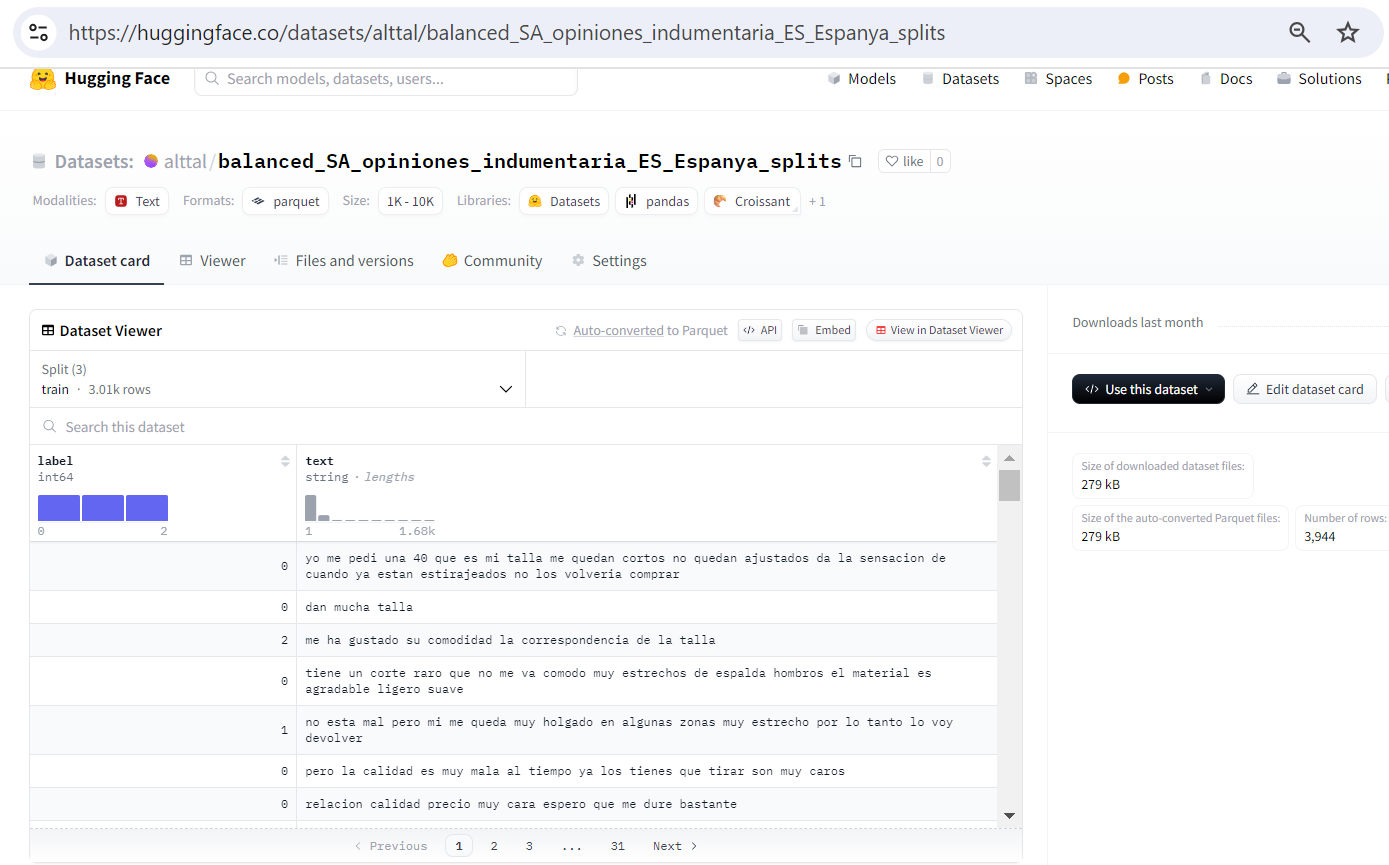